In [1]:
from datasets import load_dataset, Dataset, concatenate_datasets
import pandas as pd

# Load the CSV with finger count results
df = pd.read_csv("finger_count_results.csv")
uuid_choices = df.set_index("uuid")["choice"].to_dict()
valid_uuids = set(uuid_choices.keys())

In [2]:
# Count the occurrences of each choice in the original DataFrame
choice_counts_df = df["choice"].value_counts()

print("\nChoice distribution from original data:")
print(choice_counts_df)


Choice distribution from original data:
choice
five               7125
six                2976
seven               340
four                 96
cannot_identify      55
eight                44
nine                 13
ten                   5
three                 3
more_than_11          3
Name: count, dtype: int64


In [3]:
# First, let's get the count of 'six' samples to use as our target
target_count = df["choice"].value_counts()["six"]

# Create a balanced DataFrame by:
# 1. Separating fives and non-fives
# 2. Randomly sampling fives to match target count
# 3. Combining back together
df_without_fives = df[df["choice"] != "five"]
df_fives = df[df["choice"] == "five"].sample(n=target_count, random_state=42)

# Combine the DataFrames and reset the index
df_balanced = pd.concat([df_without_fives, df_fives]).reset_index(drop=True)

# Remove more_than_11 entries and reset the index
df_balanced = df_balanced[df_balanced["choice"] != "more_than_11"].reset_index(
    drop=True
)

# Remove more_than_11 entries and reset the index
df_balanced = df_balanced[df_balanced["choice"] != "cannot_identify"].reset_index(
    drop=True
)

# Verify the new counts
print("\nChoice distribution after removing more_than_11:")
print(df_balanced["choice"].value_counts())


Choice distribution after removing more_than_11:
choice
six      2976
five     2976
seven     340
four       96
eight      44
nine       13
ten         5
three       3
Name: count, dtype: int64


In [4]:
# ... existing code ...

# Create mapping dictionary for string to integer conversion
number_mapping = {
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "eleven": 11,
}

# Convert 'choice' column directly to integers
df_balanced["choice"] = df_balanced["choice"].map(number_mapping)

# Verify the conversion
print("\nChoice distribution after conversion to integers:")
print(df_balanced["choice"].value_counts())


Choice distribution after conversion to integers:
choice
6     2976
5     2976
7      340
4       96
8       44
9       13
10       5
3        3
Name: count, dtype: int64


In [5]:
from datasets import load_dataset, Dataset, concatenate_datasets
import pandas as pd

# Load the CSV with finger count results
# df = pd.read_csv("finger_count_results.csv")
uuid_choices = df_balanced.set_index("uuid")["choice"].to_dict()
valid_uuids = set(uuid_choices.keys())

# Load the hands dataset
CACHE_DIR = "/Volumes/EXTRA/HF_TEMP"
hands_dataset = load_dataset(
    "taesiri/HumanHandsDataset", cache_dir=CACHE_DIR, split="train"
)

# Filter for examples that have matching UUIDs in the CSV first
filtered_dataset = hands_dataset.filter(
    lambda x: x["uuid"] in valid_uuids, desc="Filtering for matching UUIDs"
)


def add_choice(example):
    """Add choice from CSV if UUID exists"""
    uuid = example["uuid"]
    example["choice"] = uuid_choices[uuid]  # No need for .get() since we filtered
    return example


# Add the choice column to the filtered dataset
combined_dataset = filtered_dataset.map(
    add_choice,
    remove_columns=None,  # Keep all existing columns
    desc="Adding choices to dataset",
)

# Verify the combined dataset
print("Combined dataset first example:", combined_dataset[0])
print("\nDataset size:", len(combined_dataset))
print("\nAvailable features:", combined_dataset.features)

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

Combined dataset first example: {'uuid': 'jLi5x9dcsKDC3RAvBmFweD', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x768 at 0x169B56170>, 'prompt': 'A mystical, otherworldly digital painting of a human hand with shimmering auras with one oversized finger, in a mysterious, foggy atmosphere.', 'seed': 147943599, 'choice': 5}

Dataset size: 6442

Available features: {'uuid': Value(dtype='string', id=None), 'image': Image(mode=None, decode=True, id=None), 'prompt': Value(dtype='string', id=None), 'seed': Value(dtype='int64', id=None), 'choice': Value(dtype='int64', id=None)}


In [6]:
def add_qa_columns(example):
    """Add problem and solution columns to each example"""
    example["problem"] = "How many fingers are in the image?"
    example["solution"] = f"<answer> {example['choice']} </answer>"
    return example


# Add the new columns to the dataset
combined_dataset = combined_dataset.map(
    add_qa_columns,
    remove_columns=None,  # Keep all existing columns
    desc="Adding problem and solution columns",
)

# Verify the new columns
print("Example with new columns:", combined_dataset[0])
print("\nAvailable features:", combined_dataset.features)

Example with new columns: {'uuid': 'jLi5x9dcsKDC3RAvBmFweD', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x768 at 0x16808EE30>, 'prompt': 'A mystical, otherworldly digital painting of a human hand with shimmering auras with one oversized finger, in a mysterious, foggy atmosphere.', 'seed': 147943599, 'choice': 5, 'problem': 'How many fingers are in the image?', 'solution': '<answer> 5 </answer>'}

Available features: {'uuid': Value(dtype='string', id=None), 'image': Image(mode=None, decode=True, id=None), 'prompt': Value(dtype='string', id=None), 'seed': Value(dtype='int64', id=None), 'choice': Value(dtype='int64', id=None), 'problem': Value(dtype='string', id=None), 'solution': Value(dtype='string', id=None)}


In [7]:
combined_dataset[0]

{'uuid': 'jLi5x9dcsKDC3RAvBmFweD',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x768>,
 'prompt': 'A mystical, otherworldly digital painting of a human hand with shimmering auras with one oversized finger, in a mysterious, foggy atmosphere.',
 'seed': 147943599,
 'choice': 5,
 'problem': 'How many fingers are in the image?',
 'solution': '<answer> 5 </answer>'}

6


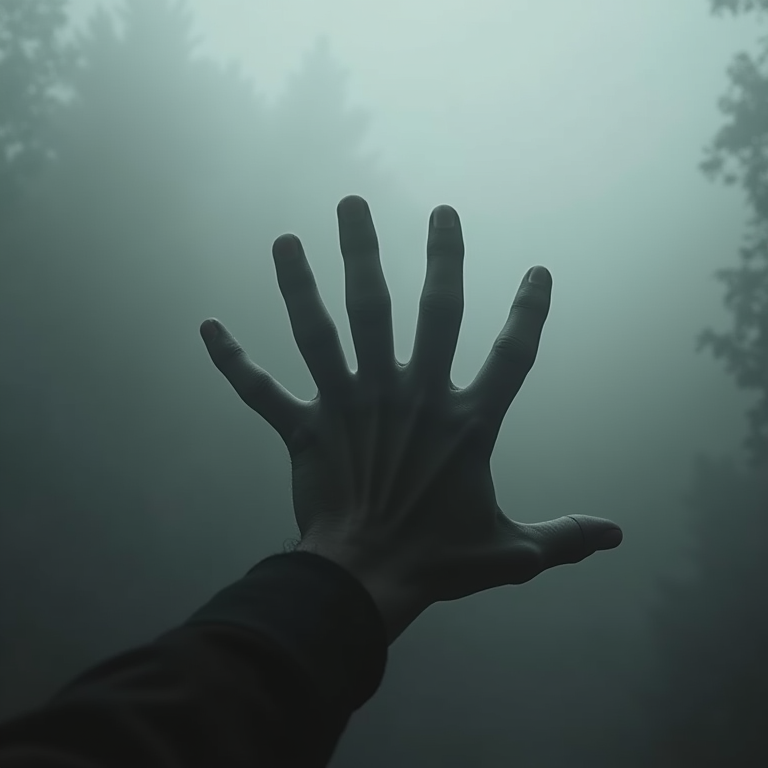

In [8]:
import random

random_id = random.choice(range(len(combined_dataset)))
print(combined_dataset[random_id]["choice"])
combined_dataset[random_id]["image"]

In [14]:
# from PIL import Image


# def resize_image(example):
#     """Resize image to 512x512 while maintaining aspect ratio"""
#     image = example["image"]
#     resized_image = image.resize((512, 512), Image.Resampling.LANCZOS)
#     example["image"] = resized_image
#     return example


# # Add the resizing to the dataset
# combined_dataset = combined_dataset.map(
#     resize_image,
#     remove_columns=None,  # Keep all existing columns
#     desc="Resizing images to 512x512",
# )

# # Verify the new image size
print("New image size:", combined_dataset[0]["image"].size)

New image size: (768, 768)


In [10]:
combined_dataset = combined_dataset.rename_column("choice", "counts")

In [13]:
combined_dataset

Dataset({
    features: ['uuid', 'image', 'prompt', 'seed', 'counts', 'problem', 'solution'],
    num_rows: 6442
})

In [15]:
combined_dataset.push_to_hub("taesiri/FluxHands-FingerCount")

Uploading the dataset shards:   0%|          | 0/9 [00:00<?, ?it/s]

Map:   0%|          | 0/716 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Volumes/SecondHeart/miniconda3/envs/defaulttorch2/lib/python3.10/site-packages/huggingface_hub/lfs.py:336: UserWarning: hf_transfer is enabled but does not support uploading from bytes or BinaryIO, falling back to regular upload
  warnings.warn(


Map:   0%|          | 0/716 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/716 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/716 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/716 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/716 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/716 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/715 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/715 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/496 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/taesiri/FluxHands-FingerCount/commit/9faa83aa1ab91d10c5fcd54b3fa4f712bae24254', commit_message='Upload dataset', commit_description='', oid='9faa83aa1ab91d10c5fcd54b3fa4f712bae24254', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/taesiri/FluxHands-FingerCount', endpoint='https://huggingface.co', repo_type='dataset', repo_id='taesiri/FluxHands-FingerCount'), pr_revision=None, pr_num=None)